In [1]:
%load_ext autoreload  
%autoreload 2  
import os
# BLAS uyarısını susturmak ve Numba'yı aktif etmek için:
os.environ["PYTENSOR_FLAGS"] = "mode=NUMBA"

Data Nesnesi:      minimum_time  minimum_time_error       weights  minimum_type      labels
0    2.454532e+06            0.000015  4.444444e+09             0  Literature
1    2.454533e+06            0.000015  4.444444e+09             0  Literature
2    2.454536e+06            0.000015  4.444444e+09             0  Literature
3    2.454537e+06            0.000015  4.444444e+09             0  Literature
4    2.454555e+06            0.000015  4.444444e+09             0  Literature
..            ...                 ...           ...           ...         ...
465  2.460740e+06            0.000029  1.167229e+09             0    Ždánice 
466  2.460460e+06            0.000028  1.275510e+09             0    Ždánice 
467  2.460069e+06            0.000014  5.102041e+09             0    Ždánice 
468  2.460057e+06            0.000003  1.111111e+11             0    Ždánice 
469  2.460461e+06            0.000003  1.111111e+11             0    Ždánice 

[470 rows x 5 columns]
OCPyMC Nesnesi:      minim

(<Figure size 1000x540 with 1 Axes>, <Axes: xlabel='Cycle', ylabel='O−C'>)

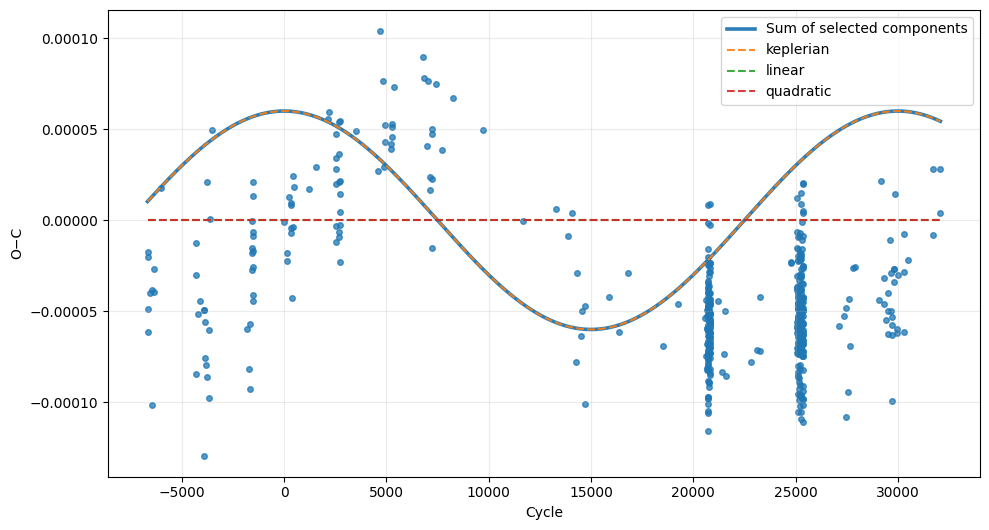

In [2]:
from ocpy.data import Data
from ocpy.oc import Keplerian, Linear, Parameter, Quadratic
from ocpy.oc_pymc import OCPyMC

excel_path = "DD_CrB_Minima_.xlsx"

from ocpy.data import Data

import pandas as pd
from ocpy.oc import OC  # oc.py dosyasının proje yapınıza göre doğru import edildiğinden emin olun

from ocpy.data import Data

# Dosya yolu
file_path = "dd_crb.csv"

# 'dd_crb.csv' dosyasına özel sütun eşleştirmeleri
column_mapping = {
    "Mintimes": "minimum_time",      # Zamanlar
    "Errors": "minimum_time_error",  # Hatalar
    "Mintypes": "minimum_type",      # Minima türü (0, 1 vb.)
    "Data_group": "labels"           # Gözlem grupları/Kaynaklar
}

# 1. Data nesnesini oluştur
data = Data.from_file(file_path, columns=column_mapping)

# Ağırlıkları hata paylarına göre hesapla (dosyada 'Errors' olduğu için yapılabilir)
if data.data["minimum_time_error"].notna().all():
    data = data.calculate_weights()

# 2. OCPyMC nesnesini oluştur
# Bu dosyadaki verilere uygun yaklaşık T0 ve Periyot değerleri:
t0 = 2455611.92657 
period = 0.161770446 

oc = data.calculate_oc(
    reference_minimum=t0,
    reference_period=period,
    model_type="pymc"
)

# Sonuçları yazdır
print("Data Nesnesi:", data)
print("OCPyMC Nesnesi:", oc)

print(oc.data.head())

# LiTE (Keplerian) tablodan
kep = Keplerian(
    amp=Parameter(
        value=6e-05,
        std=4e-5,
        min=0.0,
        max=1e-4,
        fixed=False,
    ),
    e=Parameter(
        value=0,
        std=.1,
        min=0.0,
        max=0.95,
        fixed=True,
    ),
    omega=Parameter(
        value=90,   # 85.01659 deg
        std=180,
        min=0.0,
        max=360.0,
        fixed=True,
    ),
    P=Parameter(
        value=3e+04,
        std=10000,
        min=10000,
        fixed=False,
    ),
    T0=Parameter(
        value=3e+04,
        std=30000,
        fixed=False,
    ),
)

# Linear tablodan (dP, dT)
lin = Linear(
    a=Parameter(
        value=0,
        std=1e-9,
        min=-1e-9,
        fixed=False,
    ),
    b=Parameter(
        value=0,
        std=1e-4,
        min=-1e-4,
        fixed=False,
    ),
)

quad = Quadratic(
    q=Parameter(
        value=0,
        std=1e-9,
        min=-1e-9,
        fixed=False,
    ),
)

oc.plot_components_on_data([kep, lin, quad])


In [3]:
from ocpy.oc import Linear, Quadratic, Keplerian, KeplerianOld, Parameter

res = oc.fit(
    [kep, lin, quad], 
    tune=2000,          # Test için sayıyı düşürdüm, çalışırsa artırın
    draws=2000, 
    chains=4,           # 2 zincir yeterli
    target_accept=0.95, # 0.98 çok katı olabilir, 0.95 ile başlayın
    progressbar=True,
    init="adapt_diag"   # Jitter bazen sorun çıkarabilir
)

amp =  keplerian1_amp
e =  keplerian1_e
omega =  keplerian1_omega
P =  keplerian1_P
T0 =  keplerian1_T0
a =  linear2_a
b =  linear2_b
q =  quadratic3_q


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [keplerian1_amp, keplerian1_P, keplerian1_T0, linear2_a, linear2_b, quadratic3_q]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 80 seconds.


amp =  3.9785000482963414e-05
e =  0.0
omega =  90.0
P =  28064.65390111983
T0 =  34388.273310616176
a =  1.6920618971952146e-09
b =  -2.0727351430184032e-06
q =  -1.362468394129886e-13


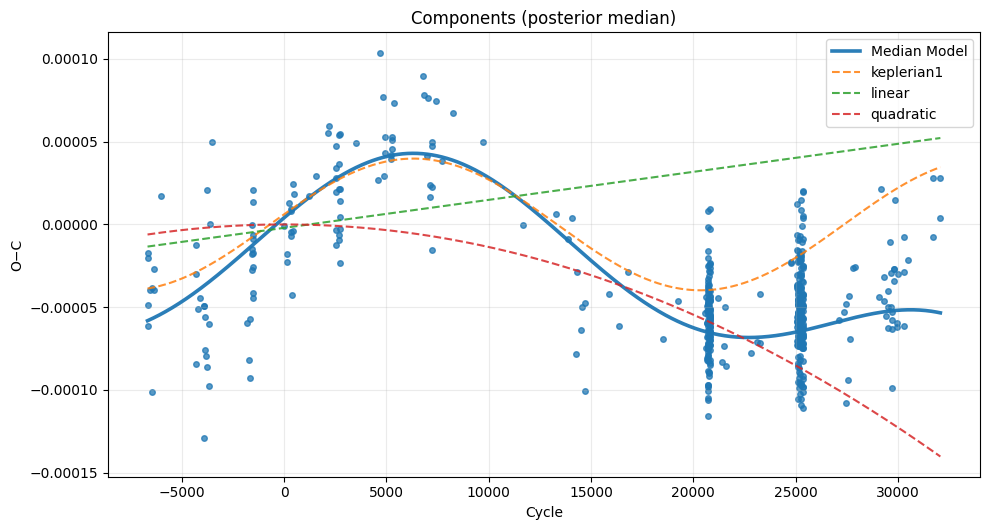

In [4]:
oc.fit_and_report(res)

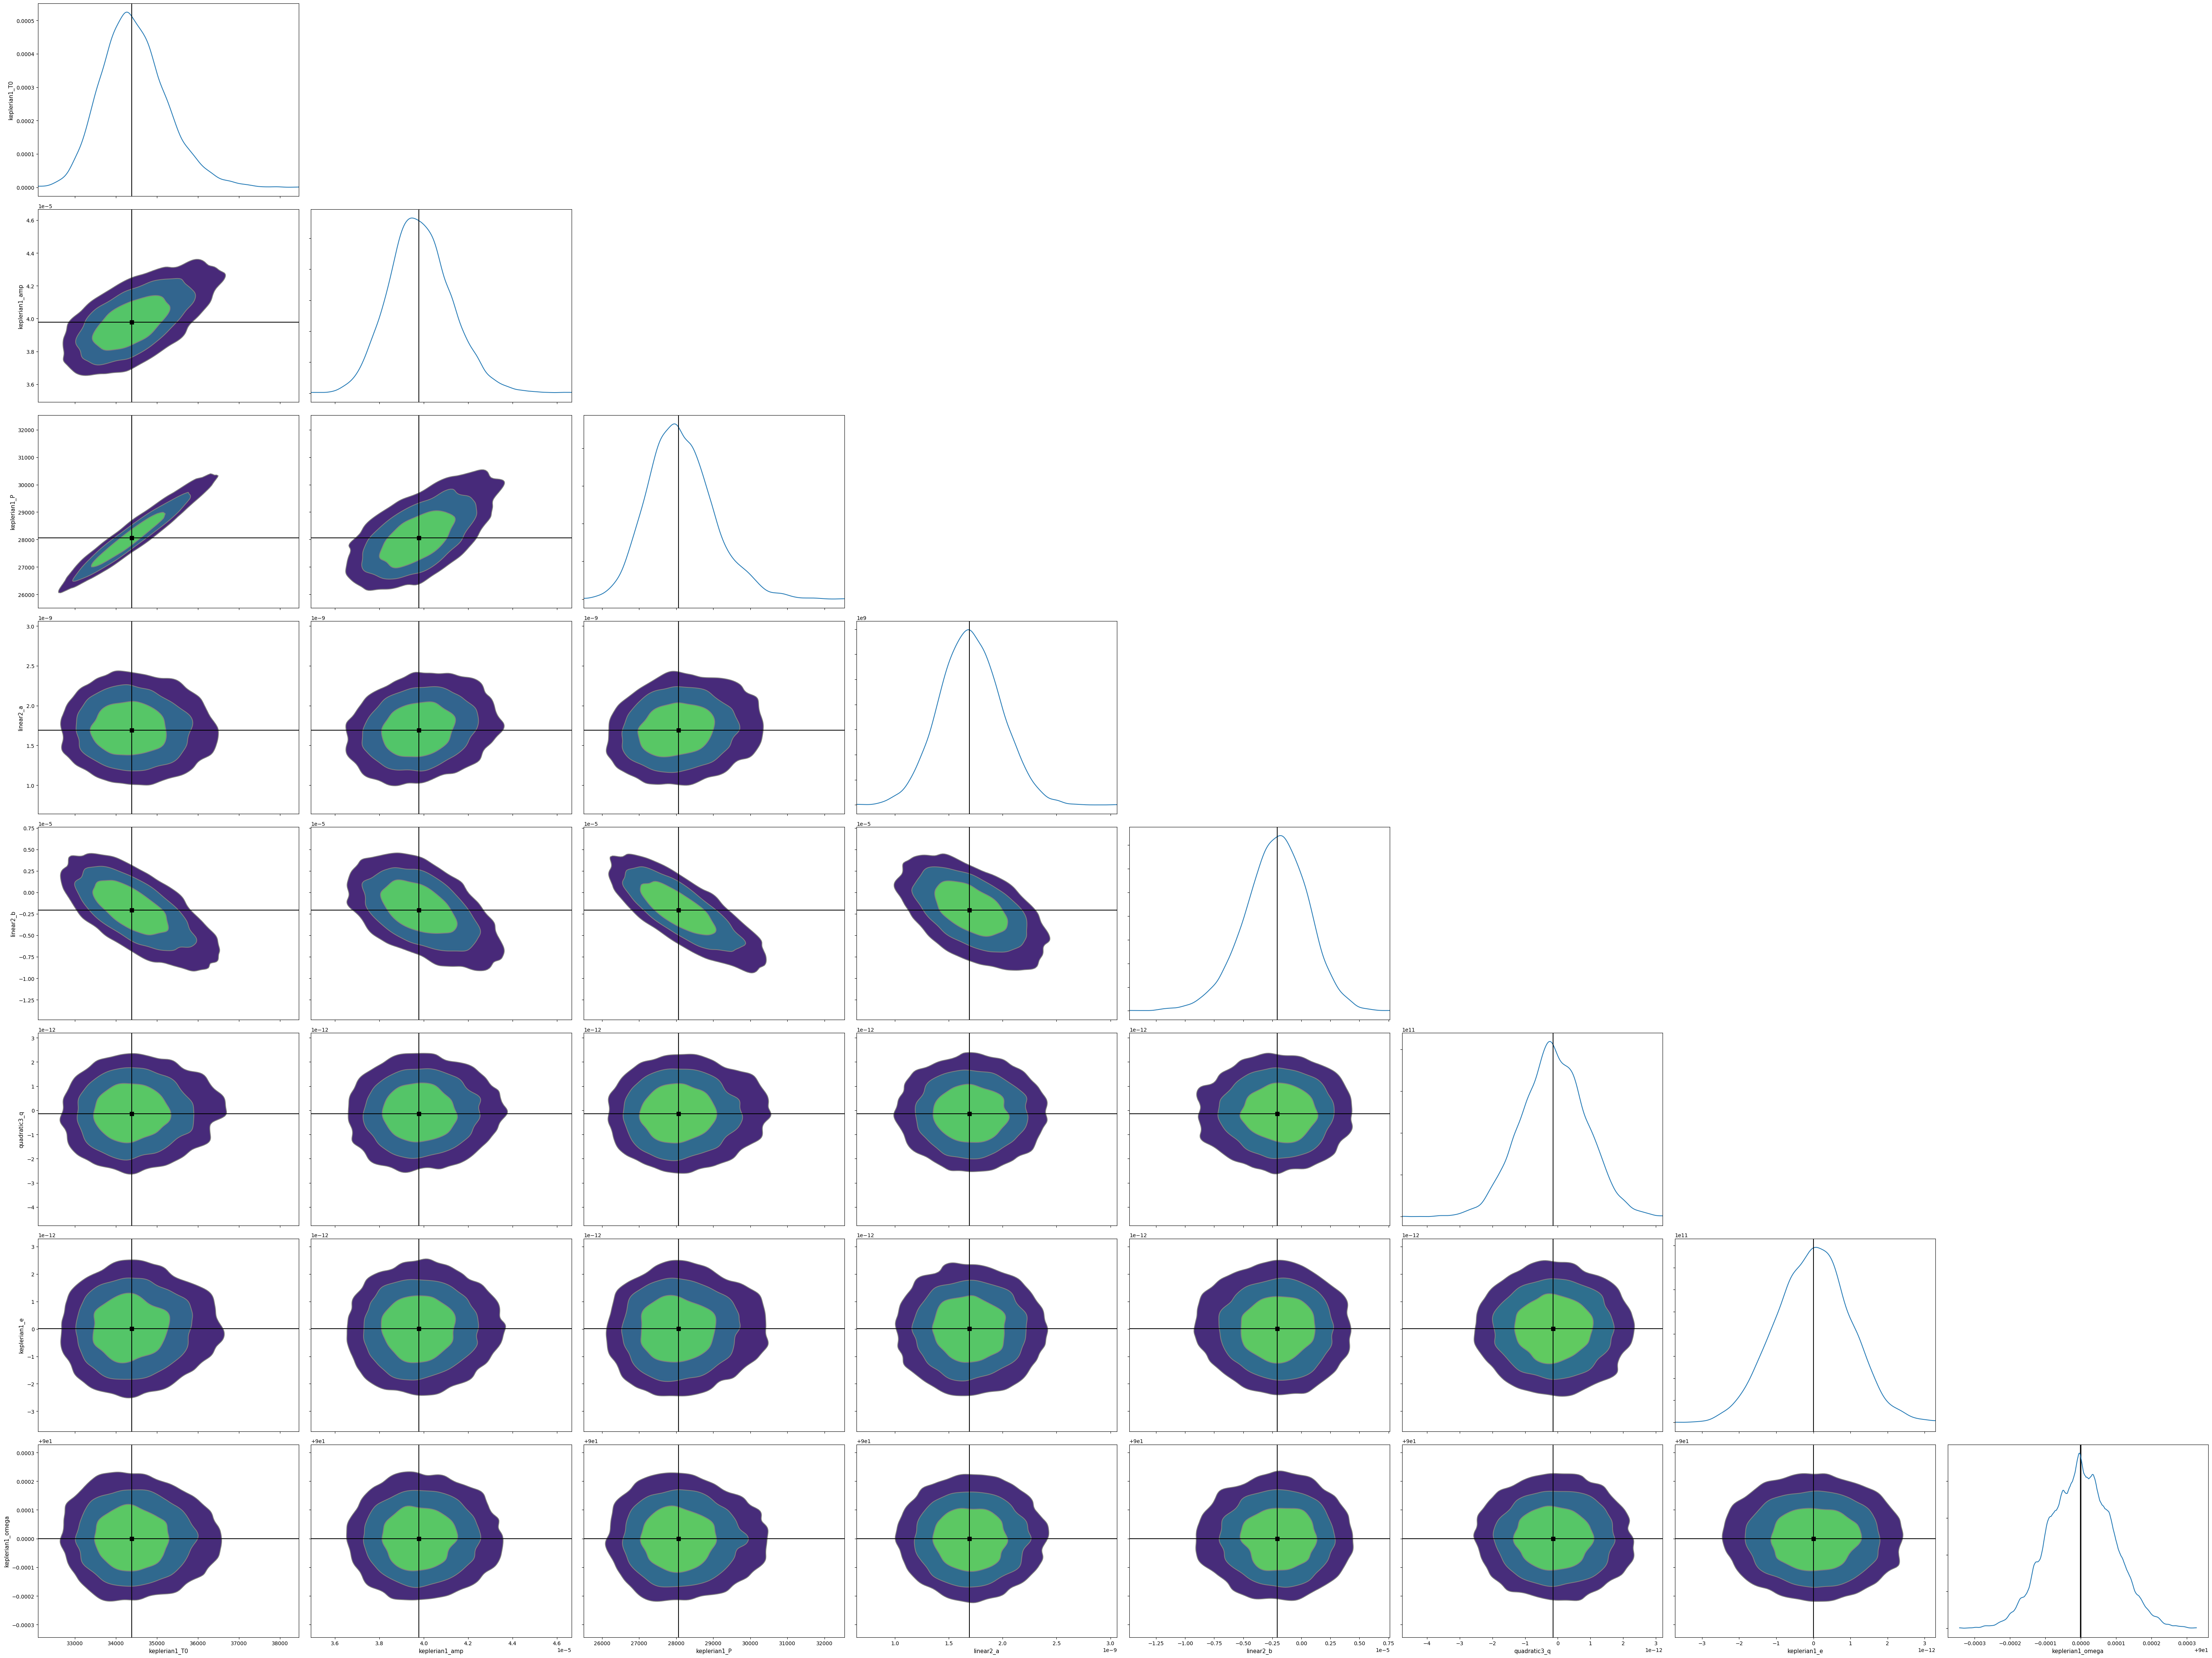

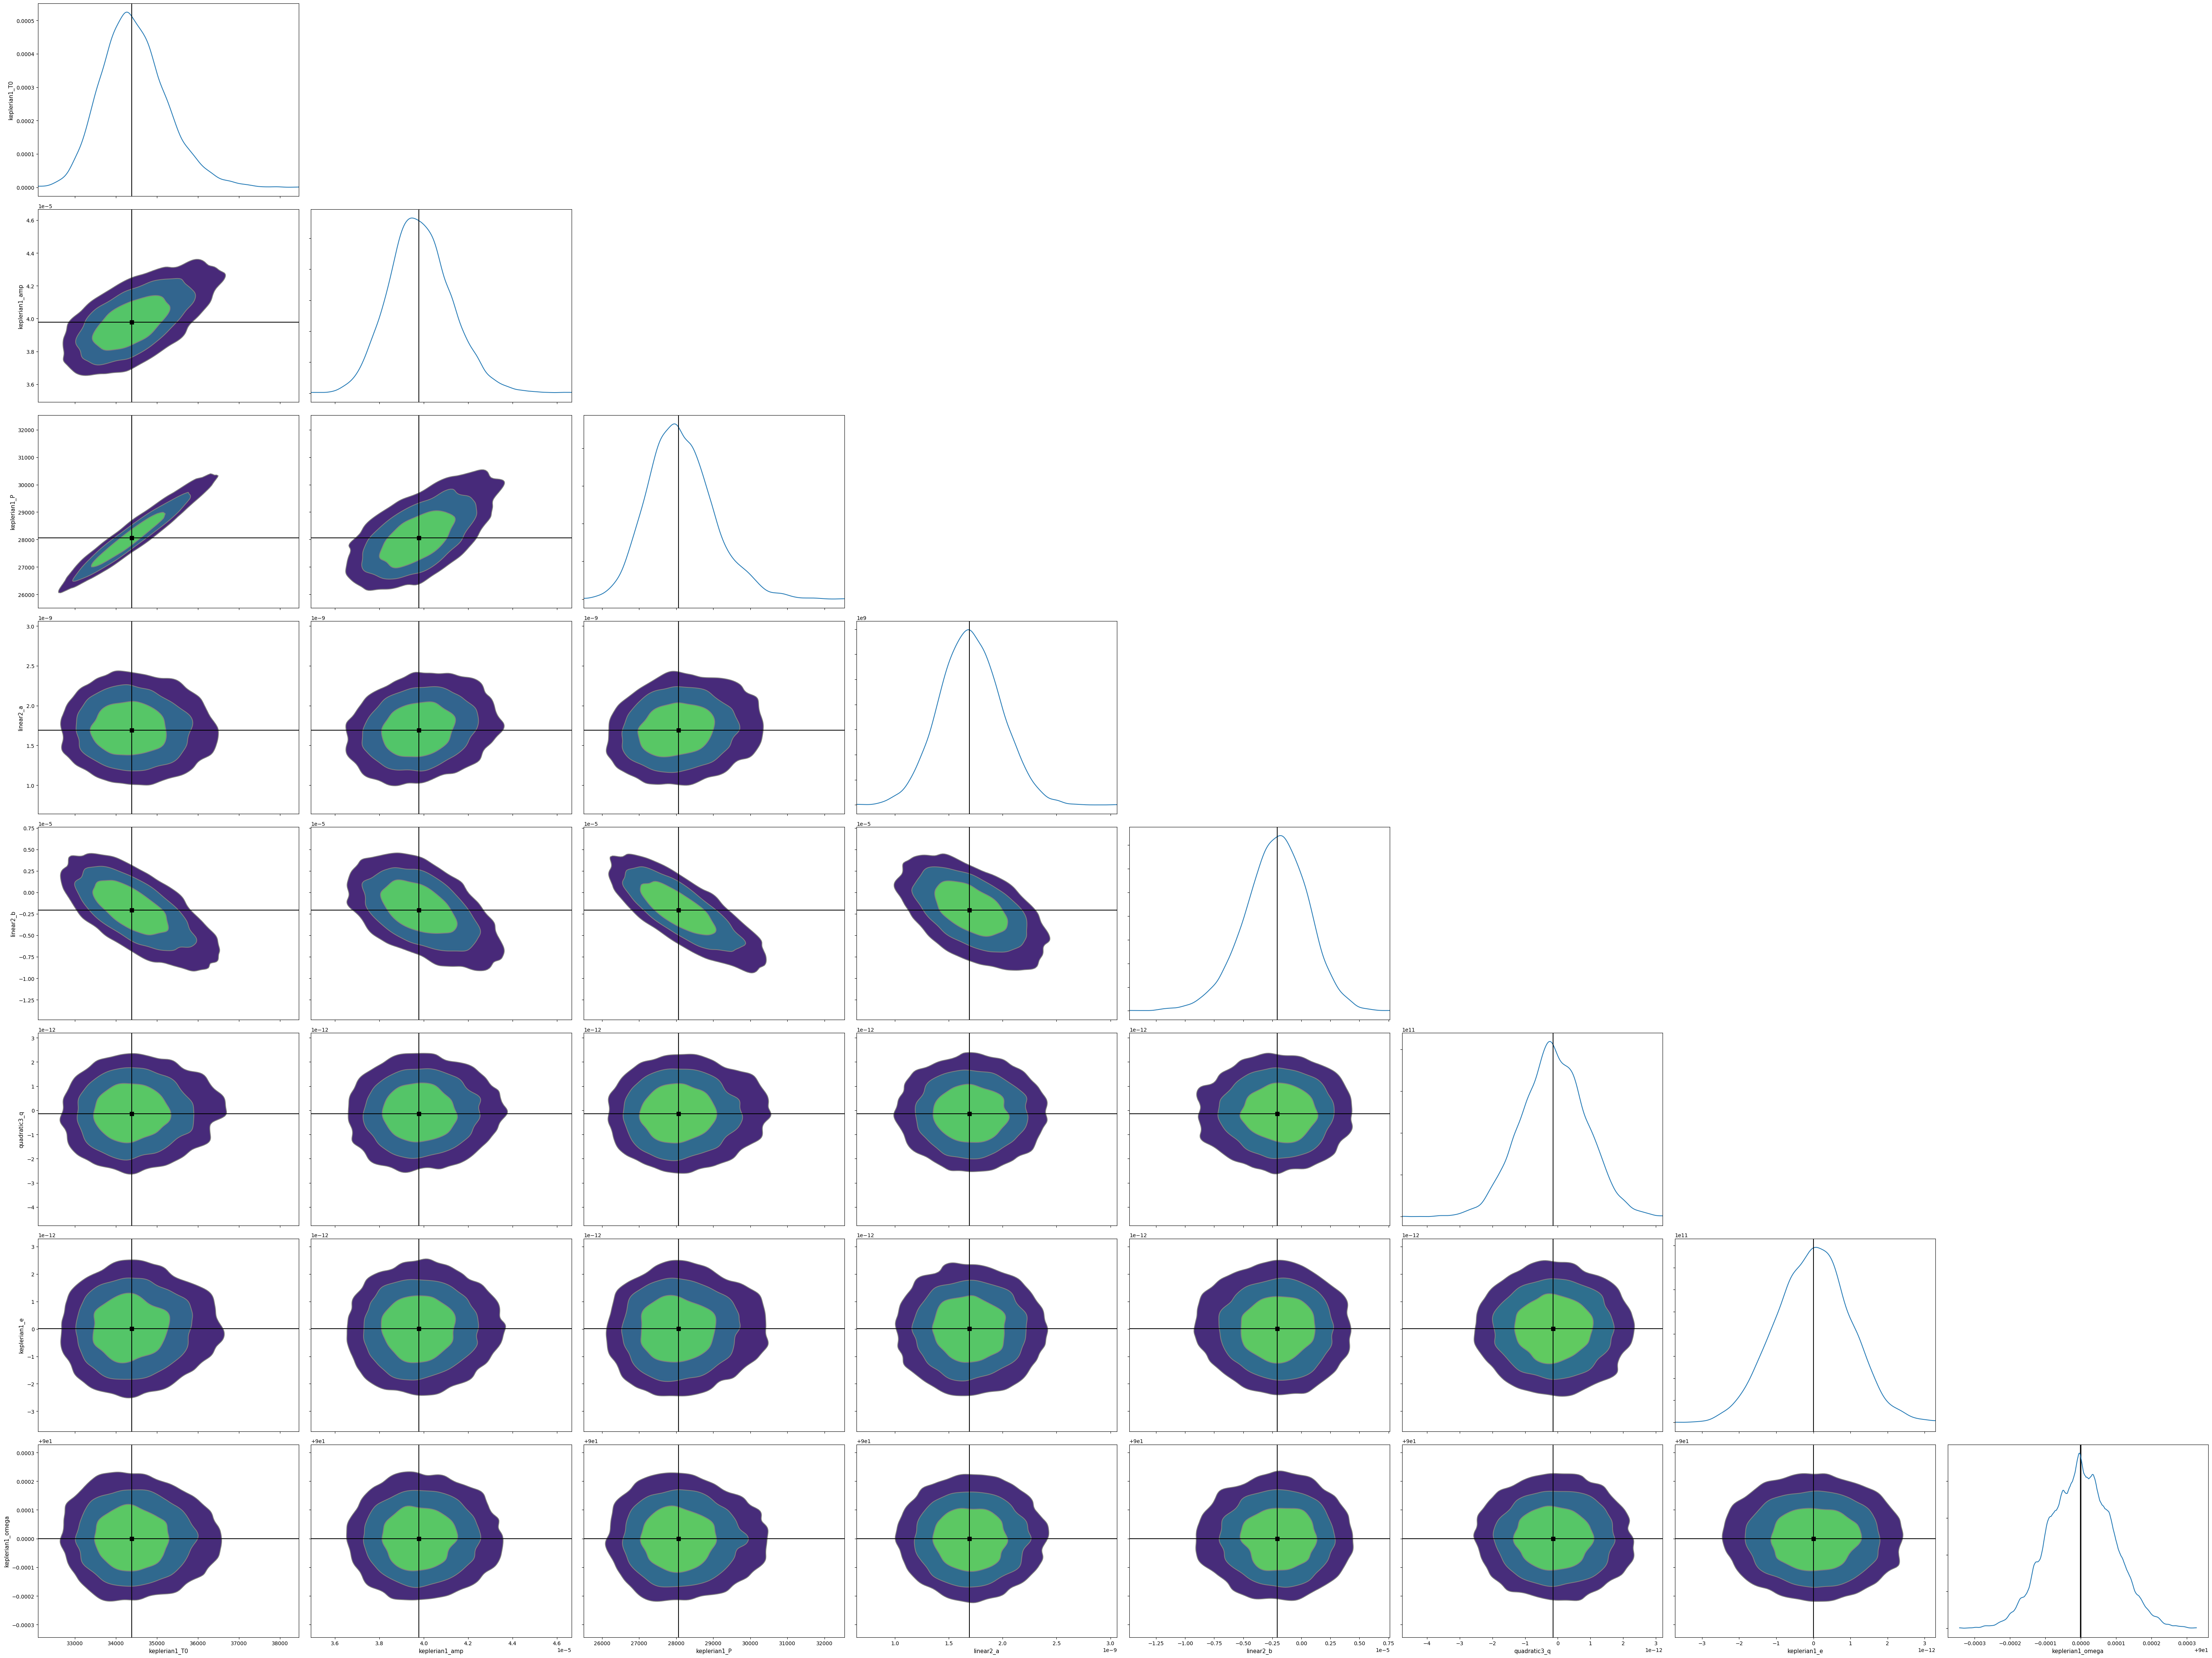

In [7]:
oc.create_corner_plot(res)

In [8]:
res.posterior.median()

<xarray.Dataset> Size: 64B
Dimensions:           ()
Data variables:
    keplerian1_T0     float64 8B 3.439e+04
    keplerian1_amp    float64 8B 3.979e-05
    keplerian1_P      float64 8B 2.806e+04
    linear2_a         float64 8B 1.692e-09
    linear2_b         float64 8B -2.073e-06
    quadratic3_q      float64 8B -1.362e-13
    keplerian1_e      float32 4B 0.0
    keplerian1_omega  float32 4B 90.0
    y_model           float64 8B -6.371e-05
Attributes:
    created_at:                 2025-11-26T22:08:18.054301+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              80.20610046386719
    tuning_steps:               2000

In [9]:
import numpy as np

# 1. Modelin 'best fit' (medyan) eğrisini çekiyoruz
# Posterior dağılımındaki tüm zincirlerin medyanını alır
y_model_posterior = res.posterior["y_model"]
y_model_median = y_model_posterior.median(dim=("chain", "draw")).values

# 2. Gerçek gözlem verilerini ve hataları alıyoruz
y_obs = oc.data["oc"].to_numpy()
y_err = oc.data["minimum_time_error"].to_numpy()

# 3. Chi-Square Formülü: sum((Obs - Model)^2 / Error^2)
chi2 = np.sum(((y_obs - y_model_median) / y_err) ** 2)

# 4. Reduced Chi-Square (İndirgenmiş Ki-Kare) Hesapla
# Serbestlik Derecesi (DOF) = Gözlem Sayısı (N) - Parametre Sayısı (k)
N = len(y_obs)

# Değişken parametre sayısını (k) otomatik bulalım:
# (y_model ve y_obs gibi değişkenleri hariç tutuyoruz)
param_names = [v for v in res.posterior.data_vars if "y_model" not in v and "obs" not in v]
k = len(param_names)

red_chi2 = chi2 / (N - k)

print(f"Toplam Veri Sayısı (N): {N}")
print(f"Serbest Parametre Sayısı (k): {k}")
print("-" * 30)
print(f"Chi-Square (χ²): {chi2:.4f}")
print(f"Reduced Chi-Square (χ²_red): {red_chi2:.4f}")

Toplam Veri Sayısı (N): 470
Serbest Parametre Sayısı (k): 8
------------------------------
Chi-Square (χ²): 1557.6239
Reduced Chi-Square (χ²_red): 3.3715
